# Tip Prediction

In this project we have worked on the data for Taxis in New York. The project aims to build a model which will predict whether
whether a ride will get a tip or not and if yes how much will be the tip. The open source libraries used are :
Shapely
- Scikit learn
- tabulate
- pandas
- numpy

In [29]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, json, requests, pickle
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate #print of tables. source: http://txt.arboreus.com/2013/03/13/pretty-print-tables-in-python.html
from shapely.geometry import Point,Polygon,MultiPoint
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [30]:
# Read the tripdata_2015-09 dataset
if os.path.exists('tripdata_2015-09.csv'): # Check if the dataset is present on local disk and load it
    data = pd.read_csv('tripdata_2015-09.csv')
else: # Download dataset if not available on disk
    url = "https://opal.ils.unc.edu/~hyadav/Comp755/tripdata_2015-09.csv"
    data = pd.read_csv(url)
    data.to_csv(url.split('/')[-1])

# Print the rows and columns of the dataset
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 1494926
Number of columns: 22


The Trip distance graph is drawn with outliers and without outliers, Outliers are defined as any point located further than 
3 standard deviations from the mean. The lognorm fit is applied on without outliers graph and it can be seen that the graph
is skewed towards right.

We hypothesis that the trips are not random as the we do not see the Gaussian distribution in the grahs drawn below. This skewed
nature tells that the taxi hire might be driven by different causes like people being pushed for common causes of reaching
early to workplace etc.

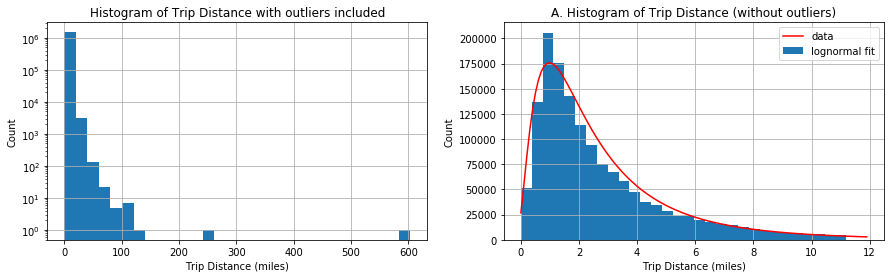

In [31]:
# define the figure with 2 trip distance subplots
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# histogram of the number of trip distance
data.Trip_distance.hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Distance with outliers included')

# vector creation to contain Trip Distance
v = data.Trip_distance 
# outlier removal by excluding any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v[~((v-v.median()).abs()>3*v.std())].hist(bins=30,ax=ax[1]) # 
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('A. Histogram of Trip Distance (without outliers)')

# apply a lognormal fit. Use the mean of trip distance as the scale parameter
scatter,loc,mean = lognorm.fit(data.Trip_distance.values,
                               scale=data.Trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),600000*pdf_fitted,'r') 
ax[1].legend(['data','lognormal fit'])

# save the figure
plt.savefig('Picture1.jpeg',format='jpeg')
plt.show()

Below is the analysis of mean and median trip distance grouped under different hours to understand the trean of trip distances
by hour of the day. It can be seen that the long trips are in the mornings and evenings although the peaks in evenings are
shorter than the peaks in mornings. It can be hypothesized that a lot trips which arise in the mornings can include trips
with longer distance like long trips to ariports etc. In the nex section we will compare the trips to Airport separately.

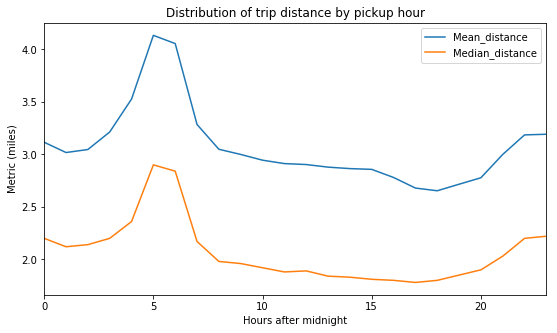

-----Trip distance by hour of the day-----

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          3.11528               2.2
     1          3.01735               2.12
     2          3.04618               2.14
     3          3.21295               2.2
     4          3.52656               2.36
     5          4.13347               2.9
     6          4.05515               2.84
     7          3.28439               2.17
     8          3.04845               1.98
     9          2.99911               1.96
    10          2.94448               1.92
    11          2.91202               1.88
    12          2.90306               1.89
    13          2.87829               1.84
    14          2.8643                1.83
    15          2.85704               1.81
    16          2.77985               1.8
    17          2.67911               1.78
    18          2.65322               1.8
    19          2.7156                1.85
    20         

In [32]:
# First, convert pickup and drop off datetime variable in their specific right format which will useful for our predictive model
data['Pickup_dt'] = data.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Dropoff_dt'] = data.Lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# Second, create a new variable for pickup hours
data['Pickup_hour'] = data.Pickup_dt.apply(lambda x:x.hour)

# Mean and Median of trip distance by pickup hour
# We generate the table and generate a plot for a visual insights

fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate Trip_distance by hour
table1 = data.pivot_table(index='Pickup_hour', values='Trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours after midnight')
plt.title('Distribution of trip distance by pickup hour')
plt.xlim([0,23])
plt.savefig('Picture2.jpeg',format='jpeg')
plt.show()
print('-----Trip distance by hour of the day-----\n')
print(tabulate(table1.values.tolist(),["Hour","Mean distance","Median distance"]))

In order to study the trips that originate/end from/to the airport we can use the dictionary of variables. THe variable RateCodeID 
contains values indicating the final rate that was applied. Among these ID we selected the IDs for JFK and Newark airports namely
2 snd 3. THe belwo graphs show the number, .eam fare of the trips and the distribution of the trips sidtances by hour of the day.
The trip distance distribution shows two peaks. Airport trips follow the same trend as the rest of the trips for short trips 
(trip distance ≤ 2miles). there is also an increased number of long range trips (18 miles) which might correspond to a great 
number people coming to airports from further residential areas. A check on google map shows that the distance between JFK and 
Manhattan is about 18 miles whereas Newark to Manhattan is 15 miles. We also notice that our assumption that long trip counts in the 
morning might be due the large number of airport trips is not quite right as in the morning the airport trips are in low number.


In [33]:
# select airport trips to get a separate data portion in a variable
airports_trips = data[(data.RateCodeID==2) | (data.RateCodeID==3)]
print("Number of trips to/from NYC airports: ", airports_trips.shape[0])
print("Average fare (calculated by the meter) of trips to/from NYC airports: $", airports_trips.Fare_amount.mean(),"per trip")
print("Average total charged amount (before tip) of trips to/from NYC airports: $", airports_trips.Total_amount.mean(),"per trip")

Number of trips to/from NYC airports:  5552
Average fare (calculated by the meter) of trips to/from NYC airports: $ 48.976945244956774 per trip
Average total charged amount (before tip) of trips to/from NYC airports: $ 57.20842038904719 per trip


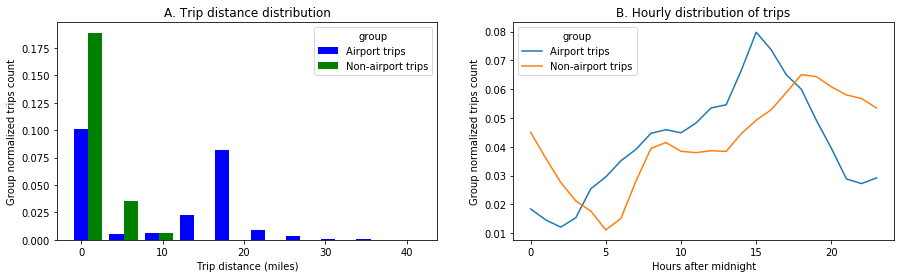

In [34]:
# create a vector to contain Trip Distance for
v2 = airports_trips.Trip_distance # airport trips
v3 = data.loc[~data.index.isin(v2.index),'Trip_distance'] # non-airport trips

# remove outliers: 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v2 = v2[~((v2-v2.median()).abs()>3*v2.std())]
v3 = v3[~((v3-v3.median()).abs()>3*v3.std())] 

# define bins boundaries
bins = np.histogram(v2,normed=True)[1]
h2 = np.histogram(v2,bins=bins,normed=True)
h3 = np.histogram(v3,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (15,4))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=w,color='b')
ax[0].bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='g')
ax[0].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
ax[0].set_xlabel('Trip distance (miles)')
ax[0].set_ylabel('Group normalized trips count')
ax[0].set_title('A. Trip distance distribution')

# plot hourly distribution of Airport and Non-airport trips
airports_trips.Pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[1])
data.loc[~data.index.isin(v2.index),'Pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Hours after midnight')
ax[1].set_ylabel('Group normalized trips count')
ax[1].set_title('B. Hourly distribution of trips')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
plt.savefig('Picture3.jpeg',format='jpeg')
plt.show()

Now build a derived variable for tip as a percentage of the total fare. Since the initial charge for NYC green taxi is $2.5,
any transaction with a smaller total amount is invalid, thus it is to be dropped.

In [35]:
data = data[(data.Total_amount>=2.5)] #cleaning
data['Tip_percentage'] = 100*data.Tip_amount/data.Total_amount
print("Summary: Tip percentage\n",data.Tip_percentage.describe())

Summary: Tip percentage
 count    1.487767e+06
mean     6.665932e+00
std      8.875835e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_percentage, dtype: float64


In below point we do a comparision between trips to/from airports with rest of the trips and we mainly focus on the trips 
originating from upper manhatttan
In order to recognize the trip from upper manhattan we follow below stategy:
- From googgle map, we collect latitude and longitude data of at least 12 points that approximately define the bounding box of 
  upper Manhattan
- We create a polygon using shapely.geometry.Polygon
- We check if the polygon contains a location defined by (latitude,longitude)

In [36]:
# import library for polygon development
from shapely.geometry import Point,Polygon,MultiPoint
# data points that define the bounding box of the Upper Manhattan
umanhattan = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]

poi = Polygon(umanhattan)
# create a function to check if a location is located inside Upper Manhattan
def is_within_bbox(loc,poi=poi):
    """
    This function returns 1 if a location loc(lat,lon) is located inside a polygon of interest poi
    loc: tuple, (latitude, longitude)
    poi: shapely.geometry.Polygon, polygon of interest
    """
    return 1*(Point(loc).within(poi))
tic = dt.datetime.now()
# Create a new variable to check if a trip originated in Upper Manhattan
data['U_manhattan'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)
print("Processing time ", dt.datetime.now()-tic)

Processing time  0:01:21.843181


The two distributions look the same however the t-test results in a zero p-value to imply that the two groups are different
at 95% level of condidence

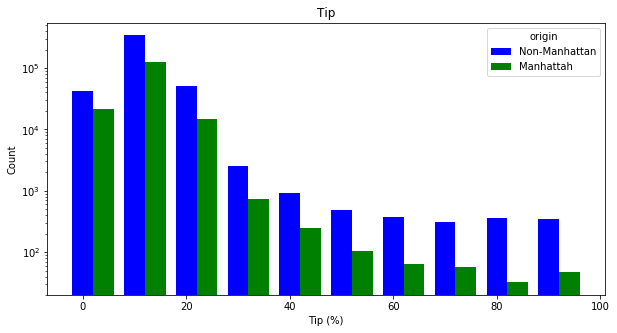

t-test results: Ttest_indResult(statistic=55.958566779306864, pvalue=0.0)


In [37]:
# create a vector to contain Tip percentage for
v1 = data[(data.U_manhattan==0) & (data.Tip_percentage>0)].Tip_percentage
v2 = data[(data.U_manhattan==1) & (data.Tip_percentage>0)].Tip_percentage

# generate bins and histogram values
bins = np.histogram(v1,bins=10)[1]
h1 = np.histogram(v1,bins=bins)
h2 = np.histogram(v2,bins=bins)

# generate the plot
# First suplot: visualize all data with outliers
fig,ax = plt.subplots(1,1,figsize=(10,5))
w = .4*(bins[1]-bins[0])
ax.bar(bins[:-1],h1[0],width=w,color='b')
ax.bar(bins[:-1]+w,h2[0],width=w,color='g')
ax.set_yscale('log')
ax.set_xlabel('Tip (%)')
ax.set_ylabel('Count')
ax.set_title('Tip')
ax.legend(['Non-Manhattan','Manhattah'],title='origin')
plt.show()
print('t-test results:', ttest_ind(v1,v2,equal_var=False))

Since we have played around with data with gives us pretty good idea of the entire data set now we can proceed to constuctively 
work on aour predictive model. Broadly we will follow four steps namely:
- Data Cleaning
- Feature Enginnering
- Exploratory Data Analysis
- Model Building
The cleaning maily consists of replacing invalid values like missing values or values not allowed for specific variables as per
the dictionary of variables with with the most frequent values in each categorical variable whereas the median was used for 
continuous numerical variables. Here variables were also converted in their appropriate format such datetime.
In feature engineering we created 10 variables which from derived from the existing variables like pickup and dropoff 
locations and timestamps, trip distance.
In Data Exploraiton we analyzed each variable closely which involved comparision to other variables and eventually the target
variable, Percentage tip. We found that the numerical variables had poweer distribution or lognormal distribution. We also found
that only 40% of the transactions paid tip. And 99.99% of these payments were done by credit cards. This made us build our model
in two stages:
- Classification model to find out weither a transaction will pay tip and 
- Regression model to find the percentage of the tip only if the transaction was classified as a tipper.
In building our model we mainly used random forest regression and gradient boosting classifier algorithms implemented in
sklearn after routines to optimize best parameters


In [38]:
# Download the tripdata_2015-09 dataset
if os.path.exists('tripdata_2015-09.csv'): # Check if the dataset is present on local disk and load it
    data = pd.read_csv('tripdata_2015-09.csv')
else: # Download dataset if not available on disk
    url = "https://opal.ils.unc.edu/~hyadav/Comp755/tripdata_2015-09.csv"
    data = pd.read_csv(url)
    data.to_csv(url.split('/')[-1])

# Print the rows and columns of the dataset
print("Number of rows:", data.shape[0])
print("Number of columns: ", data.shape[1])

# create backup dataset
backup_data = data.copy()

Number of rows: 1494926
Number of columns:  22


# Cleaning 
- This part concerns work done to treat invalid data.
- Ehail_fee was removed since 99% of the data are missing.
- Missing values in Trip_type were replace with the most common value that was 1.
Invalid data were found in:
- RateCodeID: about 0.01% of the values were 99. These were replaced by the most common value 2.
- Extra: 0.08% of transactions had negative Extra. These were replaced by 0 as the most frequent.
- Total_amount, Fare_amount, improvement_surcharge, Tip_amount: 0.16% of values were negative. The cases were considered as being machine errors during the data entry. They were replaced by their absolute values. Furthermore, as the minimum Total_amount that is chargeable for any service is $2.5, every transaction falling below that amount was replaced by the median value of the Total_amount 11.76.

In [39]:
# define a function to clean a loaded dataset

def clean_data(adata):
    """
    This function cleans the input dataframe adata:
    . drop Ehail_fee [99% transactions are NaNs]
    . impute missing values in Trip_type
    . replace invalid data by most frequent value for RateCodeID and Extra
    . encode categorical to numeric
    . rename pickup and dropff time variables (for later use)
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe

    """
    ## make a copy of the input
    data = adata.copy()
    ## drop Ehail_fee: 99% of its values are NaNs
    if 'Ehail_fee' in data.columns:
        data.drop('Ehail_fee',axis=1,inplace=True)

    ##  replace missing values in Trip_type with the most frequent value 1
    data['Trip_type '] = data['Trip_type '].replace(np.NaN,1)
    
    ## replace all values that are not allowed as per the variable dictionary with the most frequent allowable value
    # remove negative values from Total amound and Fare_amount
    print("Negative values found and replaced by their abs")
    print("Total_amount", 100*data[data.Total_amount<0].shape[0]/float(data.shape[0]),"%")
    print("Fare_amount", 100*data[data.Fare_amount<0].shape[0]/float(data.shape[0]),"%")
    print("Improvement_surcharge", 100*data[data.improvement_surcharge<0].shape[0]/float(data.shape[0]),"%")
    print("Tip_amount", 100*data[data.Tip_amount<0].shape[0]/float(data.shape[0]),"%")
    print("Tolls_amount", 100*data[data.Tolls_amount<0].shape[0]/float(data.shape[0]),"%")
    print("MTA_tax", 100*data[data.MTA_tax<0].shape[0]/float(data.shape[0]),"%")
    data.Total_amount = data.Total_amount.abs()
    data.Fare_amount = data.Fare_amount.abs()
    data.improvement_surcharge = data.improvement_surcharge.abs()
    data.Tip_amount = data.Tip_amount.abs()
    data.Tolls_amount = data.Tolls_amount.abs()
    data.MTA_tax = data.MTA_tax.abs()
    
    # RateCodeID
    indices_oi = data[~((data.RateCodeID>=1) & (data.RateCodeID<=6))].index
    data.loc[indices_oi, 'RateCodeID'] = 2 # 2 = Cash payment was identified as the common method
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in RateCodeID were invalid.--> Replaced by the most frequent 2")
    
    # Extra
    indices_oi = data[~((data.Extra==0) | (data.Extra==0.5) | (data.Extra==1))].index
    data.loc[indices_oi, 'Extra'] = 0 # 0 was identified as the most frequent value
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in Extra were invalid.--> Replaced by the most frequent 0")
    
    # Total_amount: the minimum charge is 2.5, so we will replace every thing less than 2.5 by the median 11.76 (pre-obtained in analysis)
    indices_oi = data[(data.Total_amount<2.5)].index
    data.loc[indices_oi,'Total_amount'] = 11.76
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in total amount worth <$2.5.--> Replaced by the median 1.76")
    
    # encode categorical to numeric (We avoid to use dummy to keep dataset small)
    if data.Store_and_fwd_flag.dtype.name != 'int64':
        data['Store_and_fwd_flag'] = (data.Store_and_fwd_flag=='Y')*1
    
    # rename time stamp variables and convert them to the right format
    print("renaming variables...")
    data.rename(columns={'lpep_pickup_datetime':'Pickup_dt','Lpep_dropoff_datetime':'Dropoff_dt'},inplace=True)
    print("converting timestamps variables to right format ...")
    data['Pickup_dt'] = data.Pickup_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    
    print("Done cleaning")
    return data

In [40]:
# Run code to clean the data
data = clean_data(data)

Negative values found and replaced by their abs
Total_amount 0.16168024370437065 %
Fare_amount 0.16168024370437065 %
Improvement_surcharge 0.14816786917880886 %
Tip_amount 0.002541931841442319 %
Tolls_amount 0.0004682506023709535 %
MTA_tax 0.14629486676932504 %
0.0 % of values in RateCodeID were invalid.--> Replaced by the most frequent 2
0.08 % of values in Extra were invalid.--> Replaced by the most frequent 0
0.32 % of values in total amount worth <$2.5.--> Replaced by the median 1.76
renaming variables...
converting timestamps variables to right format ...
Done cleaning


# Feature Engineering: 
Here we created some varibales based on below reasoning-
- With_tip: This is to identify transactions with tips or not. This variable was created after discovering that 60% of 
transactions have 0 tip.
- Speed: this the ratio of Trip_distance to Trip_duration. At this level, all entries with speeds higher than 240 mph were 
dropped since this is the typical highest speed for cars commonly used as taxi
- Time variables: Week, Month_day(Day of month), Week_day (Day of week), Hour (hour of day), Shift_type (shift period of the 
day) and Trip_duration. The idea behind creating these variables is that peple are more likely to tip on the basis of the hour 
or day, for instance people tip generously over weekends as they are in a joyous mood generally.
- Trip directions: Direction_NS (is the cab moving Northt to South?) and Direction_EW (is the cab moving East to West). These are components of the two main directions, horizontal and vertical. Also we noticed that the trips from upper manhattan had different ratio of tip percentage than other boroughs. So we include one more variable that denotes whether the trip is from Upper Manhattan.

In [41]:
# Function to run the feature engineering
def engineer_features(adata):
    """
    This function create new variables based on present variables in the dataset adata. It creates:
    . Week: int {1,2,3,4,5}, Week a transaction was done
    . Week_day: int [0-6], day of the week a transaction was done
    . Month_day: int [0-30], day of the month a transaction was done
    . Hour: int [0-23], hour the day a transaction was done
    . Shift type: int {1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)}, shift of the day  
    . Speed_mph: float, speed of the trip
    . Tip_percentage: float, target variable
    . With_tip: int {0,1}, 1 = transaction with tip, 0 transction without tip
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe
    """
    
    # make copy of the original dataset
    data = adata.copy()
    
    # derive time variables
    print("deriving time variables...")
    ref_week = dt.datetime(2015,9,1).isocalendar()[1] # first week in our dataset
    data['Week'] = data.Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week+1
    data['Week_day']  = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['Month_day'] = data.Pickup_dt.apply(lambda x:x.day)
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)

    # create shift variable:  1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)
    data['Shift_type'] = np.NAN
    data.loc[data[(data.Hour>=7) & (data.Hour<15)].index,'Shift_type'] = 1
    data.loc[data[(data.Hour>=15) & (data.Hour<23)].index,'Shift_type'] = 2
    data.loc[data[data.Shift_type.isnull()].index,'Shift_type'] = 3
    
    # Trip duration 
    print("deriving Trip_duration...")
    data['Trip_duration'] = ((data.Dropoff_dt-data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))
    
    print("deriving direction variables...")
    # create direction variable Direction_NS. 
    # This is 2 if taxi moving from north to south, 1 in the opposite direction and 0 otherwise
    data['Direction_NS'] = (data.Pickup_latitude>data.Dropoff_latitude)*1+1
    indices = data[(data.Pickup_latitude == data.Dropoff_latitude) & (data.Pickup_latitude!=0)].index
    data.loc[indices,'Direction_NS'] = 0

    # create direction variable Direction_EW. 
    # This is 2 if taxi moving from east to west, 1 in the opposite direction and 0 otherwise
    data['Direction_EW'] = (data.Pickup_longitude>data.Dropoff_longitude)*1+1
    indices = data[(data.Pickup_longitude == data.Dropoff_longitude) & (data.Pickup_longitude!=0)].index
    data.loc[indices,'Direction_EW'] = 0
    
    # create variable for Speed
    print("deriving Speed. Make sure to check for possible NaNs and Inf vals...")
    data['Speed_mph'] = data.Trip_distance/(data.Trip_duration/60)
    # replace all NaNs values and values >240mph by a values sampled from a random distribution of 
    # mean 12.9 and  standard deviation 6.8mph. These values were extracted from the distribution
    indices_oi = data[(data.Speed_mph.isnull()) | (data.Speed_mph>240)].index
    data.loc[indices_oi,'Speed_mph'] = np.abs(np.random.normal(loc=12.9,scale=6.8,size=len(indices_oi)))
    print("Feature engineering done!")
    
    # Create a new variable to check if a trip originated in Upper Manhattan
    print("checking where the trip originated...")
    data['U_manhattan'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)
    
    # create tip percentage variable
    data['Tip_percentage'] = 100*data.Tip_amount/data.Total_amount
    
    # create with_tip variable
    data['With_tip'] = (data.Tip_percentage>0)*1

    return data


# collected bounding box points
umanhattan = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]

poi = Polygon(umanhattan)
# create a function to check if a location is located inside Upper Manhattan
def is_within_bbox(loc,poi=poi):
    """
    This function checks if a location loc with lat and lon is located within the polygon of interest
    input:
    loc: tuple, (latitude, longitude)
    poi: shapely.geometry.Polygon, polygon of interest
    """
    return 1*(Point(loc).within(poi))

In [42]:
# run the code to create new features on the dataset
print ("size before feature engineering:", data.shape)
data = engineer_features(data)
print ("size after feature engineering:", data.shape)

size before feature engineering: (1494926, 21)
deriving time variables...
deriving Trip_duration...
deriving direction variables...
deriving Speed. Make sure to check for possible NaNs and Inf vals...
Feature engineering done!
checking where the trip originated...
size after feature engineering: (1494926, 33)


# Exploratory Data Analysis
This was most important step of our project. A look at the distribution of the target variable, "Tip_percentage" showed that 60%
of all transactions did not give tip THe graph below shows this fact. Based on this information, the model can be built in two steps:-
- Create classification model to predict weither tip will be given or not. The variable "With_Tip" was created for the same purpose.
- Create regression model for transaction with non-zero tip

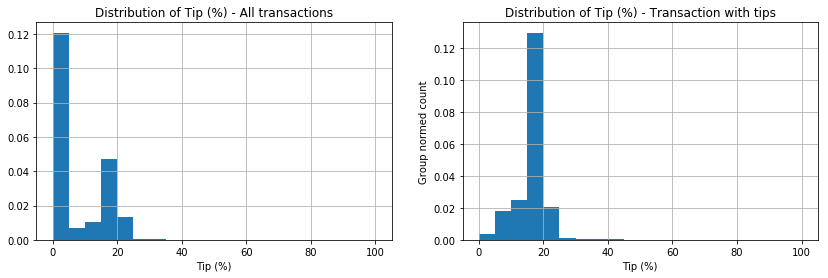

In [43]:
## code to compare the two Tip_percentage identified groups
# split data in the two groups
data1 = data[data.Tip_percentage>0]
data2 = data[data.Tip_percentage==0]

# generate histograms to compare
fig,ax=plt.subplots(1,2,figsize=(14,4))
data.Tip_percentage.hist(bins = 20,normed=True,ax=ax[0])
ax[0].set_xlabel('Tip (%)')
ax[0].set_title('Distribution of Tip (%) - All transactions')

data1.Tip_percentage.hist(bins = 20,normed=True,ax=ax[1])
ax[1].set_xlabel('Tip (%)')
ax[1].set_title('Distribution of Tip (%) - Transaction with tips')
ax[1].set_ylabel('Group normed count')
plt.savefig('picture4.jpeg',format='jpeg')
plt.show()

In [44]:
# Functions for exploratory data analysis
def visualize_continuous(df,label,method={'type':'histogram','bins':20},outlier='on'):
    """
    function to quickly visualize continous variables
    df: pandas.dataFrame 
    label: str, name of the variable to be plotted. It should be present in df.columns
    method: dict, contains info of the type of plot to generate. It can be histogram or boxplot [-Not yet developped]
    outlier: {'on','off'}, Set it to off if you need to cut off outliers. Outliers are all those points
    located at 3 standard deviations further from the mean
    """
    # create vector of the variable of interest
    v = df[label]
    # define mean and standard deviation
    m = v.mean()
    s = v.std()
    # prep of the figure
    fig,ax = plt.subplots(1,2,figsize=(14,4))
    ax[0].set_title('Distribution of '+label)
    ax[1].set_title('Tip % by '+label)
    if outlier=='off': # remove outliers accordingly and update titles
        v = v[(v-m)<=3*s]
        ax[0].set_title('Distribution of '+label+'(no outliers)')
        ax[1].set_title('Tip % by '+label+'(no outliers)')
    if method['type'] == 'histogram': # plot the histogram
        v.hist(bins = method['bins'],ax=ax[0])
    if method['type'] == 'boxplot': # plot the box plot
        df.loc[v.index].boxplot(label,ax=ax[0])
    ax[1].plot(v,df.loc[v.index].Tip_percentage,'.',alpha=0.4)
    ax[0].set_xlabel(label)
    ax[1].set_xlabel(label)
    ax[0].set_ylabel('Count')
    ax[1].set_ylabel('Tip (%)')

def visualize_categories(df,catName,chart_type='histogram',ylimit=[None,None]):
    """
    This functions helps to quickly visualize categorical variables. 
    This functions calls other functions generate_boxplot and generate_histogram
    df: pandas.Dataframe
    catName: str, variable name, it must be present in df
    chart_type: {histogram,boxplot}, choose which type of chart to plot
    ylim: tuple, list. Valid if chart_type is histogram
    """
    print(catName)
    cats = sorted(pd.unique(df[catName]))
    if chart_type == 'boxplot': #generate boxplot
        generate_boxplot(df,catName,ylimit)
    elif chart_type == 'histogram': # generate histogram
        generate_histogram(df,catName)
    else:
        pass
    
    #=> calculate test statistics
    groups = df[[catName,'Tip_percentage']].groupby(catName).groups #create groups
    tips = df.Tip_percentage
    if len(cats)<=2: # if there are only two groups use t-test
        print(ttest_ind(tips[groups[cats[0]]],tips[groups[cats[1]]]))
    else: # otherwise, use one_way anova test
        # prepare the command to be evaluated
        cmd = "f_oneway("
        for cat in cats:
            cmd+="tips[groups["+str(cat)+"]],"
        cmd=cmd[:-1]+")"
        print("one way anova test:", eval(cmd)) #evaluate the command and print
    print("Frequency of categories (%):\n",df[catName].value_counts(normalize=True)*100)
    
def test_classification(df,label,yl=[0,50]):
    """
    This function test if the means of the two groups with_tip and without_tip are different at 95% of confidence level.
    It will also generate a box plot of the variable by tipping groups
    label: str, label to test
    yl: tuple or list (default = [0,50]), y limits on the ylabel of the boxplot
    df: pandas.DataFrame (default = data)
    
    Example: run <visualize_continuous(data,'Fare_amount',outlier='on')>
    """
    
    if len(pd.unique(df[label]))==2: #check if the variable is categorical with only two  categores and run chisquare test
        vals=pd.unique(df[label])
        gp1 = df[df.With_tip==0][label].value_counts().sort_index()
        gp2 = df[df.With_tip==1][label].value_counts().sort_index()
        print("t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print(chisquare(gp1,gp2))
    elif len(pd.unique(df[label]))>=10: #other wise  run the t-test
        df.boxplot(label,by='With_tip')
        plt.ylim(yl)
        plt.show()
        print("t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print("results:",ttest_ind(df[df.With_tip==0][label].values,df[df.With_tip==1][label].values,False))
    else:
        pass

def generate_boxplot(df,catName,ylimit):
    """
    generate boxplot of tip percentage by variable "catName" with ylim set to ylimit
    df: pandas.Dataframe
    catName: str
    ylimit: tuple, list
    """
    df.boxplot('Tip_percentage',by=catName)
    plt.title('')
    plt.ylabel('Tip (%)')
    if ylimit != [None,None]:
        plt.ylim(ylimit)
    plt.show()

def generate_histogram(df,catName):
    """
    generate histogram of tip percentage by variable "catName" with ylim set to ylimit
    df: pandas.Dataframe
    catName: str
    ylimit: tuple, list
    """
    cats = sorted(pd.unique(df[catName]))
    colors = plt.cm.jet(np.linspace(0,1,len(cats)))
    hx = np.array([round(x,1) for x in np.histogram(df.Tip_percentage,bins=20)[1]])
    fig,ax = plt.subplots(1,1,figsize = (15,4))
    for i,cat in enumerate(cats):
        vals = df[df[catName] == cat].Tip_percentage
        h = np.histogram(vals,bins=hx)
        w = 0.9*(hx[1]-hx[0])/float(len(cats))
        plt.bar(hx[:-1]+w*i,h[0],color=colors[i],width=w)
    plt.legend(cats)
    plt.yscale('log')
    plt.title('Distribution of Tip by '+catName)
    plt.xlabel('Tip (%)')

The below code calls the function visualize_continuous that takes the data to plot the trip fare_amount against the count and
fare amount against tip percentage which shows that fare amount could be a good predictor variable. We performed the t-test 
and found that fare amount is a significant predictor.

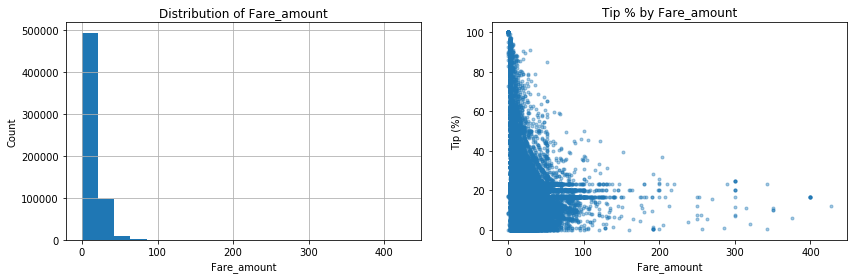

In [45]:
# Example of exploration of the Fare_amount using the implented code:
visualize_continuous(data1,'Fare_amount',outlier='on')

The code below contains a lot of functions to explores the relationship of different variables with tip_percentage. We focus on
the trips which are of longer duration i.e. more than 1350 min.  The outpt of the below shows heat map through which number of
trips between two boroughs can be found out. It ca be seen that majority of the trips are intra-boroughs.There is a great number
of trips from Brooklyn to Manhattan whereas there is no Staten Island trip that takes more than 1350 minutes. The map on the
right showhs that the cluster behaves the same way irrespective of the hour of the day

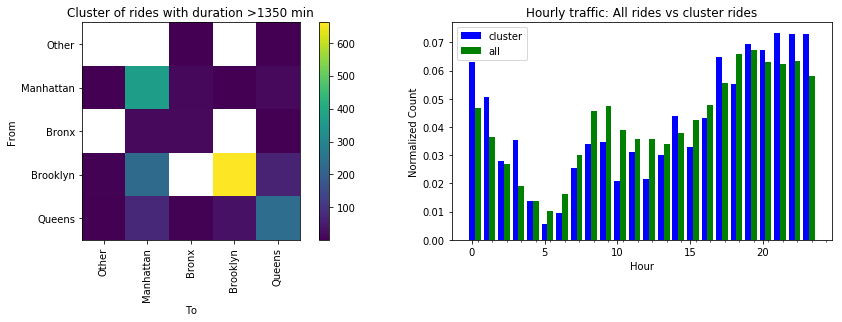

In [46]:
# Code to generate the heat map to uncover hidden information in the cluster
# We will first source NYC boroughs shape files, 
# then create polygons and check to which polygon does each of the point of the cluster begongs

## download geojson of NYC boroughs
nyc_boros = json.loads(requests.get("https://opal.ils.unc.edu/~hyadav/Comp755/boroughs.geojson").content)

# parse boros into Multipolygons
boros = {}
for f in nyc_boros['features']:
    name = f['properties']['BoroName']
    code = f['properties']['BoroCode']
    polygons = []
    for p in f['geometry']['coordinates']:
        polygons.append(Polygon(p[0]))
    boros[code] = {'name':name,'polygon':MultiPolygon(polygons=polygons)}
    
# creae function to assign each coordinates point to its borough
def find_borough(lat,lon):
    """
    return the borough of a location given its latitude and longitude
    lat: float, latitude
    lon: float, longitude
    """
    boro = 0 # initialize borough as 0
    for k,v in boros.items(): # update boro to the right key corresponding to the parent polygon
        if v['polygon'].contains(Point(lon,lat)):
            boro = k
            break # break the loop once the borough is found
    return [boro]

## Analyse the cluster now
# create data frame of boroughs
df = data1[data1.Trip_duration>=1350]
orig_dest = []
for v in df[['Pickup_latitude','Pickup_longitude','Dropoff_latitude','Dropoff_longitude']].values:
    orig_dest.append((find_borough(v[0],v[1])[0],find_borough(v[2],v[3])[0]))
df2 = pd.DataFrame(orig_dest)

## creae pivot table for the heat map plot
df2['val']=1 # dummy variable generation
mat_cluster1 = df2.pivot_table(index=0,columns=1,values='val',aggfunc='count')

## generate the map
fig,ax = plt.subplots(1,2,figsize=(15,4))
im = ax[0].imshow(mat_cluster1)
ax[0].set_ylabel('From')
ax[0].set_xlabel('To')
ax[0].set_xticklabels(['','Other','Manhattan','Bronx','Brooklyn','Queens'],rotation='vertical')
ax[0].set_yticklabels(['','Other','Manhattan','Bronx','Brooklyn','Queens'])
ax[0].set_title('Cluster of rides with duration >1350 min')
fig.colorbar(im,ax=ax[0])
h = df.Hour.value_counts(normalize=True)
plt.bar(h.index,h.values,width = .4,color='b')
h = data1.Hour.value_counts(normalize=True)
ax[1].bar(h.index+.4,h.values,width = .4,color='g')
ax[1].set_title('Hourly traffic: All rides vs cluster rides')
ax[1].legend(['cluster','all'],loc='best')
ax[1].set_xlabel('Hour')
ax[1].set_xticks(np.arange(25)+.4,list(range(25)))
ax[1].set_ylabel('Normalized Count')
plt.savefig('duration_cluster.jpeg',format='jpeg')
plt.show()

At the end, we draw a heat map of all the independent variables to see if there is a correlation which exists among 
these variables.

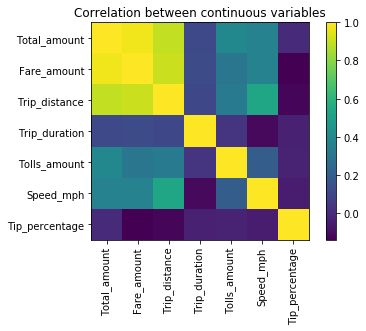

In [47]:
continuous_variables=['Total_amount','Fare_amount','Trip_distance','Trip_duration','Tolls_amount','Speed_mph','Tip_percentage']
cor_mat = data1[continuous_variables].corr()
plt.imshow(cor_mat)
plt.xticks(list(range(len(continuous_variables))),continuous_variables,rotation='vertical')
plt.yticks(list(range(len(continuous_variables))),continuous_variables)
plt.colorbar()
plt.title('Correlation between continuous variables')
plt.show()

Afterwards, a t-test was performed between the trips from upper manhattan and the trips from rest of the manhattan. We can see
that these groups have different means and the chi-square test shows that the variable can significantly distinguish between 
trips with tip and without trips.

U_manhattan


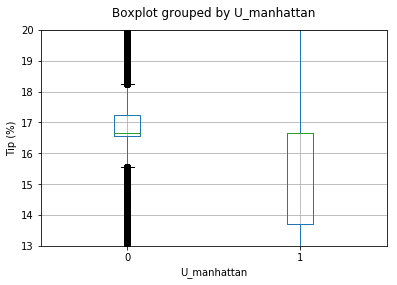

Ttest_indResult(statistic=52.88979199536133, pvalue=0.0)
Frequency of categories (%):
 0    73.053072
1    26.946928
Name: U_manhattan, dtype: float64
t-test if U_manhattan can be used to distinguish transaction with tip and without tip
Power_divergenceResult(statistic=139520.27862838889, pvalue=0.0)


In [48]:
# exploration of the U_manhattan (trip originating from Upper Manhattan) variable 
visualize_categories(data1,'U_manhattan','boxplot',[13,20])
test_classification(data,'U_manhattan')

The below function performs a one way anova to are any of the payment type which play a significant role in deciding whether
a trip ends up with a tip or not. The below distribution shows that almost 99% of the transactions with tip were paid by
payment method 1 i.e. credit card. THis variable may not be good one with respect to regression model we intend to apply to
find out the tip amount but could play a significant variable to decide whether a trip will end up in tip or not.

Similar analysis were carried on every variable in order to find the most important variables with enough variance for either 
the regression model and/or classification model. This visual exploration analysis and statistical tests section concluded by 
selecting Total_amount, Fare_amount, Trip_distance, Tolls_amount, Trip_duration, Speed_mph, U_manhattan, Direction_NS and 
Direction_EW as initial important features to train and optimized the regression model. Payment_type, Passenger_count, Extra, 
Week_day, Hour, Direction_NS, Direction_EW, U_manhattan and Shift_type were selected as initial variables to train the 
classification model.

Payment_type
one way anova test: F_onewayResult(statistic=122.42820678634747, pvalue=2.850585804911125e-79)
Frequency of categories (%):
 1    99.993364
3     0.005807
4     0.000498
2     0.000332
Name: Payment_type, dtype: float64


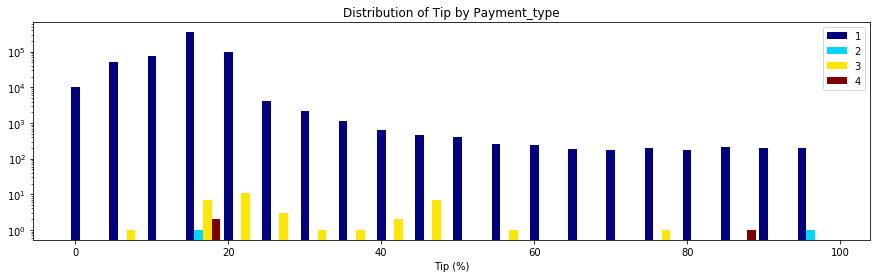

In [49]:
# visualization of the Payment_type
visualize_categories(data1,'Payment_type','histogram',[13,20])

# Model Building:
Finally we come to the phase of model building. The fist step we follow is classification, we have already see that the payment
type plays a huge role in deciding whether trp will end with tip or not. We use  GradientBoostingClassifier (from scikit learn)
which gave a score of 0.96. Starting with the GradientBoostinClassier model (default paremeters), the number of trees was 
optimized through a grid search. Below are some point about sample size and other details:

- Sample size for training and optimization was chosen as 100000. This is surely a small sample size compared to the available
data but the optimization was stable and good enough with 5 folds cross-validation.
- Only the number of trees were optimized as they are the controlling key of boosting model accuracy. Other parameters were not
optimized since the improvement yield was too small compared to the computation time and cost
- ROC-AUC (Area under the curve of receiver operating characteristic) was used as a model validation metric

Below is the summary of the result acquired through the code
- optimized number of trees: 130
- optimized variables: ['Payment_type','Total_amount','Trip_duration','Speed_mph','MTA_tax','Extra','Hour','Direction_NS', 
'Direction_EW','U_manhattan']
- roc-auc on a different test sample: 0.9636

In [50]:
# import scikit learn libraries
from sklearn import cross_validation, metrics   #model optimization and valuation tools
from sklearn.grid_search import GridSearchCV   #Perforing grid search

# define a function that help to train models and perform cv
def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    """
    This functions train the model given as 'alg' by performing cross-validation. It works on both regression and classification
    alg: sklearn model
    dtrain: pandas.DataFrame, training set
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    scoring_method: str, method to be used by the cross-validation to valuate the model
    performCV: bool, perform Cv or not
    printFeatureImportance: bool, plot histogram of features importance or not
    cv_folds: int, degree of cross-validation
    """
    # train the algorithm on data
    alg.fit(dtrain[predictors],dtrain[target])
    #predict on train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print("\nModel report:")
        if scoring_method == 'roc_auc':
            print("Accuracy:",metrics.accuracy_score(dtrain[target].values,dtrain_predictions))
            print("AUC Score (Train):",metrics.roc_auc_score(dtrain[target], dtrain_predprob))
        if (scoring_method == 'mean_squared_error'):
            print("Accuracy:",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions))
    if performCV:
        print("CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    #print feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster': #runs only if alg is xgboost
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importe Score')
        plt.show()

# optimize n_estimator through grid search
def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    """
    This functions is used to tune paremeters of a predictive algorithm
    alg: sklearn model,
    param_test: dict, parameters to be tuned
    scoring_method: str, method to be used by the cross-validation to valuate the model
    train: pandas.DataFrame, training data
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    """
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring=scoring_method,n_jobs=2,iid=False,cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch

# plot optimization results
def plot_opt_results(alg):
    cv_results = []
    for i in range(len(param_test['n_estimators'])):
        cv_results.append((alg.grid_scores_[i][1],alg.grid_scores_[i][0]['n_estimators']))
    cv_results = pd.DataFrame(cv_results)
    plt.plot(cv_results[1],cv_results[0])
    plt.xlabel('# trees')
    plt.ylabel('score')
    plt.title('optimization report')

Optimizing the classifier...
[mean: 0.98882, std: 0.00043, params: {'n_estimators': 30}, mean: 0.99319, std: 0.00023, params: {'n_estimators': 50}, mean: 0.99506, std: 0.00024, params: {'n_estimators': 70}, mean: 0.99595, std: 0.00021, params: {'n_estimators': 90}, mean: 0.99649, std: 0.00018, params: {'n_estimators': 110}, mean: 0.99689, std: 0.00019, params: {'n_estimators': 130}, mean: 0.99709, std: 0.00016, params: {'n_estimators': 150}] {'n_estimators': 150} 0.9970919710726307

Model report:
Accuracy: 0.97655
AUC Score (Train): 0.9983425569241622
CV Score - Mean : 0.997092 | Std : 0.0001615035 | Min : 0.9969115 | Max : 0.9973589


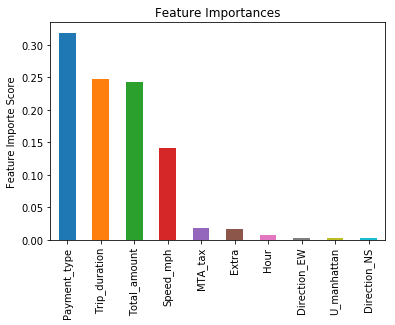

Processing time: 0:06:09.506191


In [51]:
## OPTIMIZATION & TRAINING OF THE CLASSIFIER

from sklearn.ensemble import GradientBoostingClassifier
print("Optimizing the classifier...")

train = data.copy() # make a copy of the training set
# since the dataset is too big for our system, we select a small sample size to carry on training and 5 folds cross validation
train = train.loc[np.random.choice(train.index,size=100000,replace=False)]
target = 'With_tip' # set target variable - it will be used later in optimization

tic = dt.datetime.now() # initiate the timing
# for predictors start with candidates identified during the EDA
predictors = ['Payment_type','Total_amount','Trip_duration','Speed_mph','MTA_tax',
              'Extra','Hour','Direction_NS', 'Direction_EW','U_manhattan']

# optimize n_estimator through grid search
param_test = {'n_estimators':list(range(30,151,20))} # define range over which number of trees is to be optimized


# initiate classification model
model_cls = GradientBoostingClassifier(
    learning_rate=0.1, # use default
    min_samples_split=2,# use default
    max_depth=5,
    max_features='auto',
    subsample=0.8, # try <1 to decrease variance and increase bias
    random_state = 10)

# get results of the search grid
gs_cls = optimize_num_trees(model_cls,param_test,'roc_auc',train,predictors,target)
print(gs_cls.grid_scores_, gs_cls.best_params_, gs_cls.best_score_)

# cross validate the best model with optimized number of estimators
modelfit(gs_cls.best_estimator_,train,predictors,target,'roc_auc')

# save the best estimator on disk as pickle for a later use
with open('my_classifier.pkl','wb') as fid:
    pickle.dump(gs_cls.best_estimator_,fid)
    fid.close()
    
print("Processing time:", dt.datetime.now()-tic)

In [52]:
# testing on a different set
indices = data.index[~data.index.isin(train.index)]
test = data.loc[np.random.choice(indices,size=100000,replace=False)]

ypred = gs_cls.best_estimator_.predict(test[predictors])

print("ROC AUC:", metrics.roc_auc_score(ypred,test.With_tip))

ROC AUC: 0.9678204527807158


The next step is to perform Regressional analysis. We use random forest regression for this purpose. Below are some point 
about sample size and other details:

- Sample size for training and optimization was chosen as 100000 with 5 folds cross-validation
- Only the number of trees were optimized as they are the controlling key of boosting model accuracy. Other parameters were 
not optimized since the improvement yield was too small compared to the computation time and cost
- The mean square error was used as a valuation metric

Below are resuts acquired from the code below:
- optimized number of trees: 150
- optimized variables: Total_amount, Trip_duration, Speed_mph
- mean square error on a different test sample: 14.3648 

[mean: -15.57825, std: 0.86376, params: {'n_estimators': 50}, mean: -15.55477, std: 0.77360, params: {'n_estimators': 75}, mean: -15.47482, std: 0.77679, params: {'n_estimators': 100}, mean: -15.42605, std: 0.83242, params: {'n_estimators': 125}, mean: -15.43783, std: 0.75686, params: {'n_estimators': 150}, mean: -15.35111, std: 0.82297, params: {'n_estimators': 175}] {'n_estimators': 175} -15.351105923975595

Model report:
Accuracy: 2.1607037866044476
CV Score - Mean : -15.37873 | Std : 0.8038684 | Min : -16.47665 | Max : -14.00984


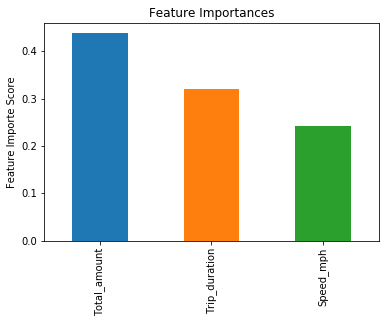

RFR test mse: 14.705532030183111
RFR r2: 0.28732108250608546
0:13:32.538537


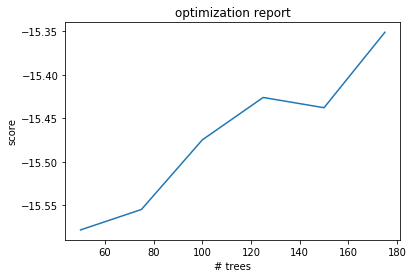

In [53]:
train = data1.copy()
train = train.loc[np.random.choice(train.index,size=100000,replace=False)]
indices = data1.index[~data1.index.isin(train.index)]
test = data1.loc[np.random.choice(indices,size=100000,replace=False)]

train['ID'] = train.index
IDCol = 'ID'
target = 'Tip_percentage'

predictors = ['VendorID', 'Passenger_count', 'Trip_distance', 'Total_amount', 
              'Extra', 'MTA_tax', 'Tolls_amount', 'Payment_type', 
              'Hour', 'U_manhattan', 'Week', 'Week_day', 'Month_day', 'Shift_type', 
              'Direction_NS', 'Direction_EW', 'Trip_duration', 'Speed_mph']
predictors = ['Trip_distance','Tolls_amount', 'Direction_NS', 'Direction_EW', 'Trip_duration', 'Speed_mph']
predictors = ['Total_amount', 'Trip_duration', 'Speed_mph']


# Random Forest
tic = dt.datetime.now()
from sklearn.ensemble import RandomForestRegressor
# optimize n_estimator through grid search
param_test = {'n_estimators':list(range(50,200,25))} # define range over which number of trees is to be optimized
# initiate classification model
rfr = RandomForestRegressor()
# get results of the search grid
gs_rfr = optimize_num_trees(rfr,param_test,'mean_squared_error',train,predictors,target)

# print optimization results
print(gs_rfr.grid_scores_, gs_rfr.best_params_, gs_rfr.best_score_)

# plot optimization results

# cross validate the best model with optimized number of estimators
modelfit(gs_rfr.best_estimator_,train,predictors,target,'mean_squared_error')

# save the best estimator on disk as pickle for a later use
with open('my_rfr_reg2.pkl','wb') as fid:
    pickle.dump(gs_rfr.best_estimator_,fid)
    fid.close()

ypred = gs_rfr.best_estimator_.predict(test[predictors])

print('RFR test mse:',metrics.mean_squared_error(ypred,test.Tip_percentage))
print('RFR r2:', metrics.r2_score(ypred,test.Tip_percentage))
print(dt.datetime.now()-tic)
plot_opt_results(gs_rfr)

# Final Overall Model
Now this is the step were we combine both our models i.e. classification and regression to get the final predictions. 
the model was run on the entire dataset to predict expected tip percentages. It resulted in a mean squared error of 0.8793.

In [54]:
def predict_tip(transaction):
    """
    This function predicts the percentage tip expected on 1 transaction
    transaction: pandas.dataframe, this should have been cleaned first and feature engineered
    """
    # define predictors labels as per optimization results
    cls_predictors = ['Payment_type','Total_amount','Trip_duration','Speed_mph','MTA_tax',
                      'Extra','Hour','Direction_NS', 'Direction_EW','U_manhattan']
    reg_predictors = ['Total_amount', 'Trip_duration', 'Speed_mph']
    
    # classify transactions
    clas = gs_cls.best_estimator_.predict(transaction[cls_predictors])
    
    # predict tips for those transactions classified as 1
    return clas*gs_rfr.best_estimator_.predict(transaction[reg_predictors])

In [55]:
test = data.loc[np.random.choice(data.index,size = 100000,replace=False)]
ypred = predict_tip(test)
print ("final mean_squared_error:", metrics.mean_squared_error(ypred,test.Tip_percentage))
print ("final r2_score:", metrics.r2_score(ypred,test.Tip_percentage))

final mean_squared_error: 8.226937192291627
final r2_score: 0.8866747596200732


Below is the plot of the residulas which pretty much okay considering almost the normal shape of the plot.

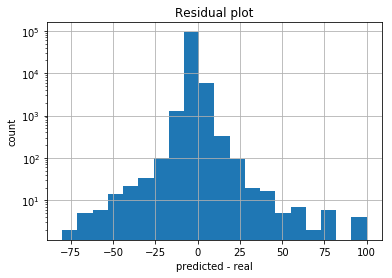

In [56]:
df = test.copy() # make a copy of data
df['predictions'] = ypred # add predictions column
df['residuals'] = df.Tip_percentage - df.predictions # calculate residuals

df.residuals.hist(bins = 20) # plot histogram of residuals
plt.yscale('log')
plt.xlabel('predicted - real')
plt.ylabel('count')
plt.title('Residual plot')
plt.show()